# 2. Frequent Itemset Mining

This notebook implements the core frequent pattern mining techniques in our project, focusing on the Apriori and FP-Growth algorithms to discover frequent itemsets and association rules.

## Objectives
- Load cleaned transaction data
- Encode transactions into a one-hot encoded boolean DataFrame
- Apply Apriori algorithm to find frequent itemsets
- Apply FP-Growth algorithm to find frequent itemsets
- Generate association rules
- Compare the performance of both algorithms

## Theoretical Background

**Frequent Itemset Mining** aims to identify sets of items that frequently appear together in transactions. Two key algorithms are:

1. **Apriori Algorithm**:
   - Based on the principle: "All subsets of a frequent itemset must be frequent"
   - Uses a level-wise approach, first finding frequent 1-itemsets, then 2-itemsets, and so on
   - Pros: Easy to understand, complete
   - Cons: Computationally expensive for large datasets due to many database scans

2. **FP-Growth Algorithm**:
   - Uses a divide-and-conquer strategy without candidate generation
   - Represents the database as a compressed FP-Tree structure
   - Pros: Usually faster than Apriori, especially for large datasets
   - Cons: More complex implementation

## Import Required Libraries

In [16]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from typing import Dict, List, Set, Tuple, Any

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Ensure directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('figures', exist_ok=True)

## Helper Functions

In [17]:
def load_json_file(file_path: str) -> Any:
    """Load data from a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def save_json_file(data: Any, file_path: str) -> None:
    """Save data to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2)


def encode_transactions(transactions: List[List[str]]) -> Tuple[pd.DataFrame, TransactionEncoder]:
    """Encode transactions into a one-hot encoded DataFrame.

    Args:
        transactions: List of transaction lists

    Returns:
        Tuple of (encoded DataFrame, TransactionEncoder instance)
    """
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    return df, te


def frozenset_to_list(df: pd.DataFrame) -> pd.DataFrame:
    """Convert frozenset columns in a DataFrame to lists for easier handling."""
    result = df.copy()

    # Convert any frozenset columns to lists
    for col in result.columns:
        if result[col].apply(lambda x: isinstance(x, frozenset)).any():
            result[col] = result[col].apply(lambda x: list(x) if isinstance(x, frozenset) else x)

    return result


def compare_algorithms(apriori_results: pd.DataFrame, fpgrowth_results: pd.DataFrame) -> Dict[str, Any]:
    """Compare results from Apriori and FP-Growth algorithms."""
    # Convert frozensets to sorted tuples for comparison
    apriori_itemsets = set(tuple(sorted(list(x))) for x in apriori_results['itemsets'])
    fpgrowth_itemsets = set(tuple(sorted(list(x))) for x in fpgrowth_results['itemsets'])

    common = apriori_itemsets.intersection(fpgrowth_itemsets)
    apriori_only = apriori_itemsets - fpgrowth_itemsets
    fpgrowth_only = fpgrowth_itemsets - apriori_itemsets

    stats = {
        'apriori_count': len(apriori_itemsets),
        'fpgrowth_count': len(fpgrowth_itemsets),
        'common_count': len(common),
        'apriori_only_count': len(apriori_only),
        'fpgrowth_only_count': len(fpgrowth_only),
        'identical_results': len(apriori_only) == 0 and len(fpgrowth_only) == 0
    }

    return stats

## Load Cleaned Transaction Data

We'll load the cleaned transaction data that we prepared in the previous notebook:

In [18]:
# Load cleaned transaction data
import os

# Get the correct path for transaction lists
current_dir = os.getcwd()
# Check if we're in notebooks folder, if so go up one level
if current_dir.endswith('notebooks'):
    project_dir = os.path.dirname(current_dir)
else:
    project_dir = current_dir

transaction_lists_path = os.path.join(project_dir, 'output', 'transaction_lists.json')

try:
    transaction_lists = load_json_file(transaction_lists_path)
    print(f"Loaded {len(transaction_lists)} cleaned transactions from previous step")

    # Show some sample transactions
    print("\nSample Cleaned Transactions:")
    for t in transaction_lists[:5]:
        print(t)
except FileNotFoundError:
    # If the cleaned data doesn't exist, load the original data
    print("Cleaned transaction data not found. Loading original data...")

    original_data_path = os.path.join(project_dir, 'data', 'transactions.json')
    try:
        transactions = load_json_file(original_data_path)
        transaction_lists = [t.get('items', []) for t in transactions]
        print(f"Loaded {len(transaction_lists)} transactions from original data")
        print("Note: Run the cleaning notebook first for best results!")
    except FileNotFoundError:
        # Create some sample data if needed
        print("Original data not found either. Creating sample data...")
        transaction_lists = [
            ["apple", "milk", "bread"],
            ["rice", "oil"],
            ["milk", "eggs", "cheese", "yogurt"],
            ["bread", "butter", "milk"],
            ["apple", "banana", "orange", "grapes"]
        ]
        print("Created 5 sample transactions")

# Load configuration
config_path = os.path.join(project_dir, 'config.json')
try:
    config = load_json_file(config_path)
    min_support = config.get('min_support', 0.2)
    min_confidence = config.get('min_confidence', 0.6)
except (FileNotFoundError, json.JSONDecodeError):
    print("Config file not found or invalid. Using default parameters.")
    min_support = 0.2
    min_confidence = 0.6

print(f"\nMining parameters:")
print(f"  Min Support: {min_support}")
print(f"  Min Confidence: {min_confidence}")

Loaded 20 cleaned transactions from previous step

Sample Cleaned Transactions:
['apple', 'milk', 'bread']
['rice', 'oil', 'beans']
['milk', 'eggs', 'cheese', 'yogurt']
['bread', 'butter', 'milk']
['apple', 'banana', 'orange', 'grapes']

Mining parameters:
  Min Support: 0.2
  Min Confidence: 0.6


## Transaction Encoding

Convert transactions to a one-hot encoded format suitable for mining algorithms:

In [19]:
# Encode transactions
encoded_df, encoder = encode_transactions(transaction_lists)

print(f"Encoded {len(transaction_lists)} transactions with {len(encoder.columns_)} unique items")

# Display a sample of the encoded data
print("\nSample of Encoded Transactions:")
print(encoded_df.head())

# Save encoded transactions to CSV
encoded_csv_path = 'output/encoded_transactions.csv'
encoded_df.to_csv(encoded_csv_path, index=False)
print(f"Saved encoded transactions to {encoded_csv_path}")

# Display the shape of the DataFrame
print(f"\nShape of encoded transactions: {encoded_df.shape}")
print(f"Sparsity: {1 - encoded_df.values.sum() / (encoded_df.shape[0] * encoded_df.shape[1]):.2f}")

Encoded 20 transactions with 25 unique items

Sample of Encoded Transactions:
   apple  bacon  banana  beans  berries  bread  butter  cereal  cheese  \
0   True  False   False  False    False   True   False   False   False   
1  False  False   False   True    False  False   False   False   False   
2  False  False   False  False    False  False   False   False    True   
3  False  False   False  False    False   True    True   False   False   
4   True  False    True  False    False  False   False   False   False   

   chicken  ...   milk    oil  orange   rice  sugar    tea  tomato  \
0    False  ...   True  False   False  False  False  False   False   
1    False  ...  False   True   False   True  False  False   False   
2    False  ...   True  False   False  False  False  False   False   
3    False  ...   True  False   False  False  False  False   False   
4    False  ...  False  False    True  False  False  False   False   

   vegetables   wine  yogurt  
0       False  False   Fa

## Frequent Itemset Mining with Apriori

Now, let's apply the Apriori algorithm to find frequent itemsets:

In [20]:
# Run Apriori algorithm and measure execution time
start_time = time.time()
apriori_frequent_itemsets = apriori(
    encoded_df,
    min_support=min_support,
    use_colnames=True,
    verbose=1
)
apriori_time = time.time() - start_time

print(f"\nApriori completed in {apriori_time:.2f} seconds")
print(f"Found {len(apriori_frequent_itemsets)} frequent itemsets")

# Display top frequent itemsets by support
print("\nTop 10 Frequent Itemsets by Support:")
display(apriori_frequent_itemsets.sort_values('support', ascending=False).head(10))

# Save frequent itemsets to CSV
apriori_itemsets_list = frozenset_to_list(apriori_frequent_itemsets)
apriori_itemsets_path = 'output/apriori_itemsets.csv'
apriori_itemsets_list.to_csv(apriori_itemsets_path, index=False)
print(f"Saved Apriori itemsets to {apriori_itemsets_path}")

Processing 20 combinations | Sampling itemset size 2

Apriori completed in 0.00 seconds
Found 5 frequent itemsets

Top 10 Frequent Itemsets by Support:


,support,itemsets
3,0.50,(milk)
1,0.30,(bread)
0,0.25,(banana)
2,0.20,(cheese)
4,0.20,(rice)


Saved Apriori itemsets to output/apriori_itemsets.csv


## Frequent Itemset Mining with FP-Growth

Let's now apply the FP-Growth algorithm for comparison:

In [21]:
# Run FP-Growth algorithm and measure execution time
start_time = time.time()
fpgrowth_frequent_itemsets = fpgrowth(
    encoded_df,
    min_support=min_support,
    use_colnames=True,
    verbose=1
)
fpgrowth_time = time.time() - start_time

print(f"\nFP-Growth completed in {fpgrowth_time:.2f} seconds")
print(f"Found {len(fpgrowth_frequent_itemsets)} frequent itemsets")

# Display top frequent itemsets by support
print("\nTop 10 Frequent Itemsets by Support:")
display(fpgrowth_frequent_itemsets.sort_values('support', ascending=False).head(10))

# Save frequent itemsets to CSV
fpgrowth_itemsets_list = frozenset_to_list(fpgrowth_frequent_itemsets)
fpgrowth_itemsets_path = 'output/fpgrowth_itemsets.csv'
fpgrowth_itemsets_list.to_csv(fpgrowth_itemsets_path, index=False)
print(f"Saved FP-Growth itemsets to {fpgrowth_itemsets_path}")

# Compare the results from both algorithms
comparison = compare_algorithms(apriori_frequent_itemsets, fpgrowth_frequent_itemsets)
print("\nAlgorithm Comparison:")
for key, value in comparison.items():
    print(f"  {key}: {value}")

# Compare execution times
print(f"\nExecution Times:")
print(f"  Apriori: {apriori_time:.2f} seconds")
print(f"  FP-Growth: {fpgrowth_time:.2f} seconds")
print(f"  Speedup: {apriori_time/fpgrowth_time:.2f}x")

5 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (milk)
0 itemset(s) from tree conditioned on items (bread)
0 itemset(s) from tree conditioned on items (rice)
0 itemset(s) from tree conditioned on items (cheese)
0 itemset(s) from tree conditioned on items (banana)

FP-Growth completed in 0.00 seconds
Found 5 frequent itemsets

Top 10 Frequent Itemsets by Support:


,support,itemsets
0,0.50,(milk)
1,0.30,(bread)
4,0.25,(banana)
2,0.20,(rice)
3,0.20,(cheese)


Saved FP-Growth itemsets to output/fpgrowth_itemsets.csv

Algorithm Comparison:
  apriori_count: 5
  fpgrowth_count: 5
  common_count: 5
  apriori_only_count: 0
  fpgrowth_only_count: 0
  identical_results: True

Execution Times:
  Apriori: 0.00 seconds
  FP-Growth: 0.00 seconds
  Speedup: 0.61x


## Generate Association Rules from Apriori

Generate association rules from the frequent itemsets found by Apriori:

In [22]:
# Generate association rules from Apriori itemsets
apriori_rules = association_rules(
    apriori_frequent_itemsets,
    metric="confidence",
    min_threshold=min_confidence
)

print(f"Generated {len(apriori_rules)} association rules from Apriori")

# Display top rules by lift
print("\nTop 10 Association Rules by Lift:")
display(apriori_rules.sort_values('lift', ascending=False).head(10))

# Save rules to CSV with correct path
apriori_rules_list = frozenset_to_list(apriori_rules)
apriori_rules_path = os.path.join(project_dir, 'output', 'apriori_rules.csv')
apriori_rules_list.to_csv(apriori_rules_path, index=False)
print(f"Saved Apriori rules to {apriori_rules_path}")

# Examine rule metrics
print("\nRule Metrics Summary:")
print(apriori_rules.describe())

Generated 0 association rules from Apriori

Top 10 Association Rules by Lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


Saved Apriori rules to e:\project-x\output\apriori_rules.csv

Rule Metrics Summary:
       antecedents consequents antecedent support consequent support support  \
count            0           0                  0                  0       0   
unique           0           0                  0                  0       0   
top            NaN         NaN                NaN                NaN     NaN   
freq           NaN         NaN                NaN                NaN     NaN   

       confidence lift representativity leverage conviction zhangs_metric  \
count           0    0                0        0          0             0   
unique          0    0                0        0          0             0   
top           NaN  NaN              NaN      NaN        NaN           NaN   
freq          NaN  NaN              NaN      NaN        NaN           NaN   

       jaccard certainty kulczynski  
count        0         0          0  
unique       0         0          0  
top        NaN 

## Generate Association Rules from FP-Growth

Generate association rules from the frequent itemsets found by FP-Growth:

In [23]:
# Generate association rules from FP-Growth itemsets
fpgrowth_rules = association_rules(
    fpgrowth_frequent_itemsets,
    metric="confidence",
    min_threshold=min_confidence
)

print(f"Generated {len(fpgrowth_rules)} association rules from FP-Growth")

# Display top rules by lift
print("\nTop 10 Association Rules by Lift:")
display(fpgrowth_rules.sort_values('lift', ascending=False).head(10))

# Save rules to CSV
fpgrowth_rules_list = frozenset_to_list(fpgrowth_rules)
fpgrowth_rules_path = 'output/fpgrowth_rules.csv'
fpgrowth_rules_list.to_csv(fpgrowth_rules_path, index=False)
print(f"Saved FP-Growth rules to {fpgrowth_rules_path}")

# Compare rules from both algorithms
apriori_rule_count = len(apriori_rules)
fpgrowth_rule_count = len(fpgrowth_rules)
print(f"\nApriori generated {apriori_rule_count} rules")
print(f"FP-Growth generated {fpgrowth_rule_count} rules")

# Check if the rules are identical
apriori_rule_tuples = set()
for _, row in apriori_rules.iterrows():
    ant = tuple(sorted(list(row['antecedents'])))
    cons = tuple(sorted(list(row['consequents'])))
    apriori_rule_tuples.add((ant, cons))

fpgrowth_rule_tuples = set()
for _, row in fpgrowth_rules.iterrows():
    ant = tuple(sorted(list(row['antecedents'])))
    cons = tuple(sorted(list(row['consequents'])))
    fpgrowth_rule_tuples.add((ant, cons))

common_rules = apriori_rule_tuples.intersection(fpgrowth_rule_tuples)
print(f"The algorithms have {len(common_rules)} rules in common")
print(f"Apriori has {len(apriori_rule_tuples - fpgrowth_rule_tuples)} unique rules")
print(f"FP-Growth has {len(fpgrowth_rule_tuples - apriori_rule_tuples)} unique rules")

Generated 0 association rules from FP-Growth

Top 10 Association Rules by Lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


Saved FP-Growth rules to output/fpgrowth_rules.csv

Apriori generated 0 rules
FP-Growth generated 0 rules
The algorithms have 0 rules in common
Apriori has 0 unique rules
FP-Growth has 0 unique rules


## Visualize Itemset Size Distribution

Let's visualize the distribution of itemset sizes for both algorithms:

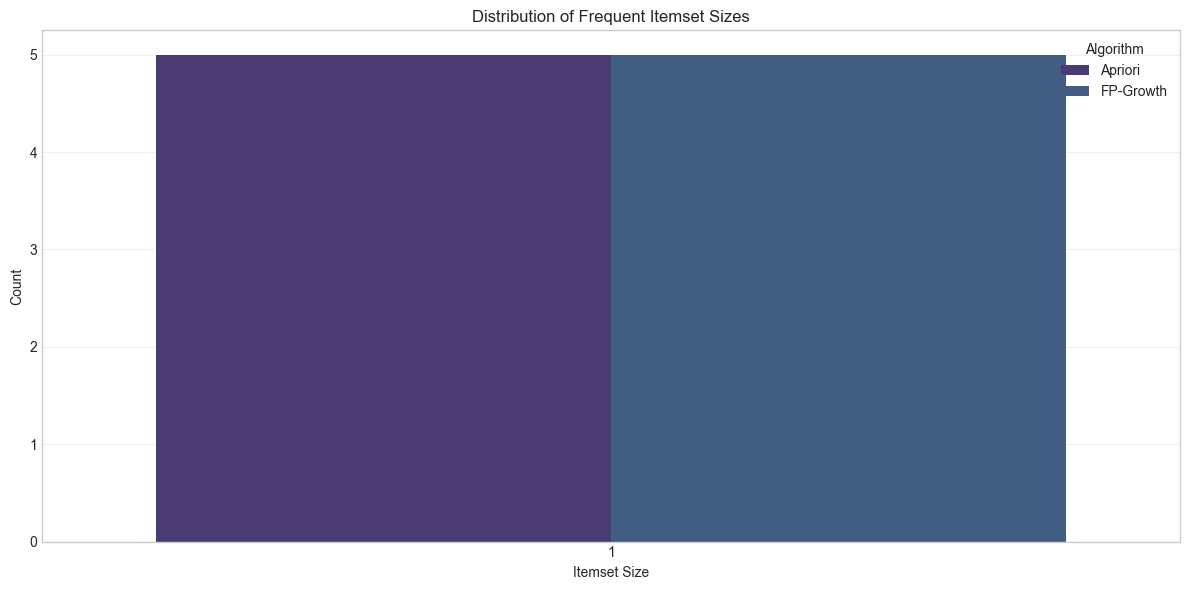

Itemset Size Statistics:
  Apriori:
    Mean: 1.00
    Median: 1.00
    Max: 1
  FP-Growth:
    Mean: 1.00
    Median: 1.00
    Max: 1


In [24]:
# Calculate itemset sizes
apriori_sizes = apriori_frequent_itemsets['itemsets'].apply(len)
fpgrowth_sizes = fpgrowth_frequent_itemsets['itemsets'].apply(len)

# Create DataFrames for plotting
apriori_size_df = pd.DataFrame({'Size': apriori_sizes, 'Algorithm': 'Apriori'})
fpgrowth_size_df = pd.DataFrame({'Size': fpgrowth_sizes, 'Algorithm': 'FP-Growth'})
combined_df = pd.concat([apriori_size_df, fpgrowth_size_df])

# Plot size distributions
plt.figure(figsize=(12, 6))
sns.countplot(x='Size', hue='Algorithm', data=combined_df)
plt.title('Distribution of Frequent Itemset Sizes')
plt.xlabel('Itemset Size')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Algorithm')

# Save the figure
plt.tight_layout()
plt.savefig('figures/itemset_size_distribution.png', dpi=300)
plt.show()

# Calculate summary statistics
print("Itemset Size Statistics:")
print("  Apriori:")
print(f"    Mean: {apriori_sizes.mean():.2f}")
print(f"    Median: {apriori_sizes.median():.2f}")
print(f"    Max: {apriori_sizes.max()}")
print("  FP-Growth:")
print(f"    Mean: {fpgrowth_sizes.mean():.2f}")
print(f"    Median: {fpgrowth_sizes.median():.2f}")
print(f"    Max: {fpgrowth_sizes.max()}")

## Visualize Rule Metrics

Let's create scatter plots to visualize the relationship between support, confidence, and lift:

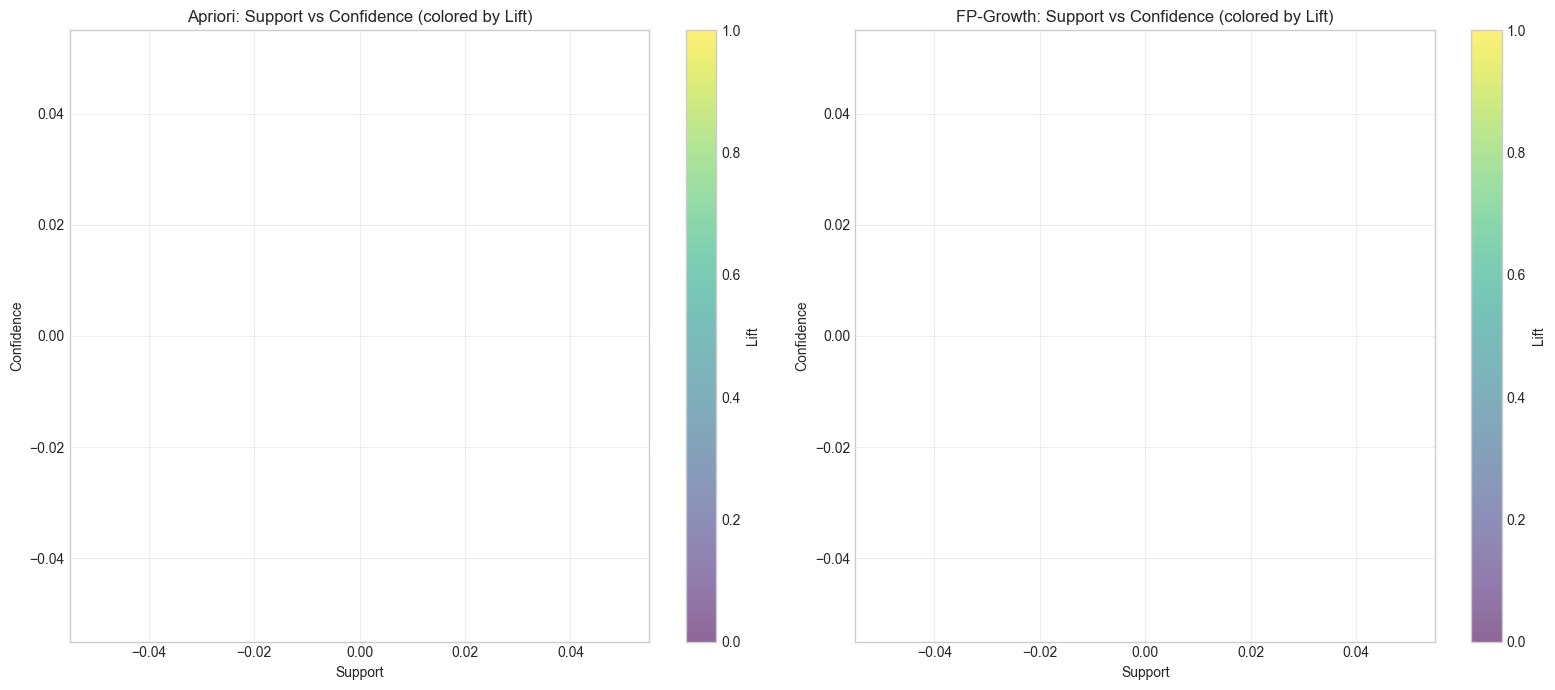

In [25]:
# Create scatter plots for both algorithms
plt.figure(figsize=(16, 7))

# Apriori
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    apriori_rules['support'],
    apriori_rules['confidence'],
    c=apriori_rules['lift'],
    cmap='viridis',
    alpha=0.6,
    s=100,
    edgecolors='w',
    linewidth=0.5
)
plt.colorbar(scatter, label='Lift')
plt.title('Apriori: Support vs Confidence (colored by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True, alpha=0.3)

# FP-Growth
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    fpgrowth_rules['support'],
    fpgrowth_rules['confidence'],
    c=fpgrowth_rules['lift'],
    cmap='viridis',
    alpha=0.6,
    s=100,
    edgecolors='w',
    linewidth=0.5
)
plt.colorbar(scatter, label='Lift')
plt.title('FP-Growth: Support vs Confidence (colored by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True, alpha=0.3)

# Save the figure
plt.tight_layout()
plt.savefig('figures/rule_scatter.png', dpi=300)
plt.show()

## Performance Comparison

Let's compare the performance of Apriori and FP-Growth:

Performance Comparison:


,Metric,Apriori,FP-Growth,Ratio (A/FP)
0,Execution Time (s),0.001702,0.002783,0.611668
1,Frequent Itemsets,5.000000,5.000000,1.000000
2,Association Rules,0.000000,0.000000,inf


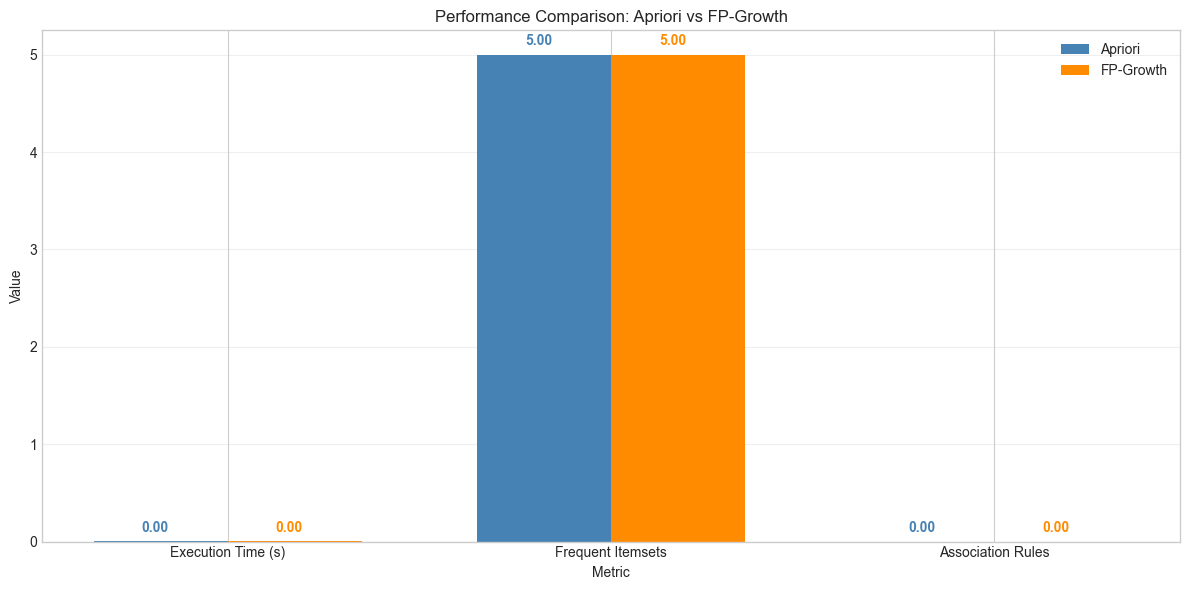

In [26]:
# Create performance comparison data
comparison_data = pd.DataFrame({
    'Metric': ['Execution Time (s)', 'Frequent Itemsets', 'Association Rules'],
    'Apriori': [apriori_time, len(apriori_frequent_itemsets), len(apriori_rules)],
    'FP-Growth': [fpgrowth_time, len(fpgrowth_frequent_itemsets), len(fpgrowth_rules)],
    'Ratio (A/FP)': [
        apriori_time / fpgrowth_time,
        len(apriori_frequent_itemsets) / len(fpgrowth_frequent_itemsets) if len(fpgrowth_frequent_itemsets) > 0 else float('inf'),
        len(apriori_rules) / len(fpgrowth_rules) if len(fpgrowth_rules) > 0 else float('inf')
    ]
})

print("Performance Comparison:")
display(comparison_data)

# Plot comparison
metrics = comparison_data['Metric'].values
apriori_values = comparison_data['Apriori'].values
fpgrowth_values = comparison_data['FP-Growth'].values

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, apriori_values, bar_width, label='Apriori', color='steelblue')
plt.bar(index + bar_width, fpgrowth_values, bar_width, label='FP-Growth', color='darkorange')

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Performance Comparison: Apriori vs FP-Growth')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(apriori_values):
    plt.text(i - 0.05, v + 0.1, f"{v:.2f}", color='steelblue', fontweight='bold')
for i, v in enumerate(fpgrowth_values):
    plt.text(i + bar_width - 0.05, v + 0.1, f"{v:.2f}", color='darkorange', fontweight='bold')

# Save the figure
plt.tight_layout()
plt.savefig('figures/performance_comparison.png', dpi=300)
plt.show()

## Sensitivity Analysis: Varying min_support

Let's analyze how the min_support parameter affects the results:

Sensitivity Analysis Results:


,min_support,itemsets_count,rules_count,runtime,avg_itemset_size,max_itemset_size
0,0.1,46,54,0.003405,1.76087,3
1,0.2,5,0,0.001494,1.00000,1
2,0.3,2,0,0.000969,1.00000,1


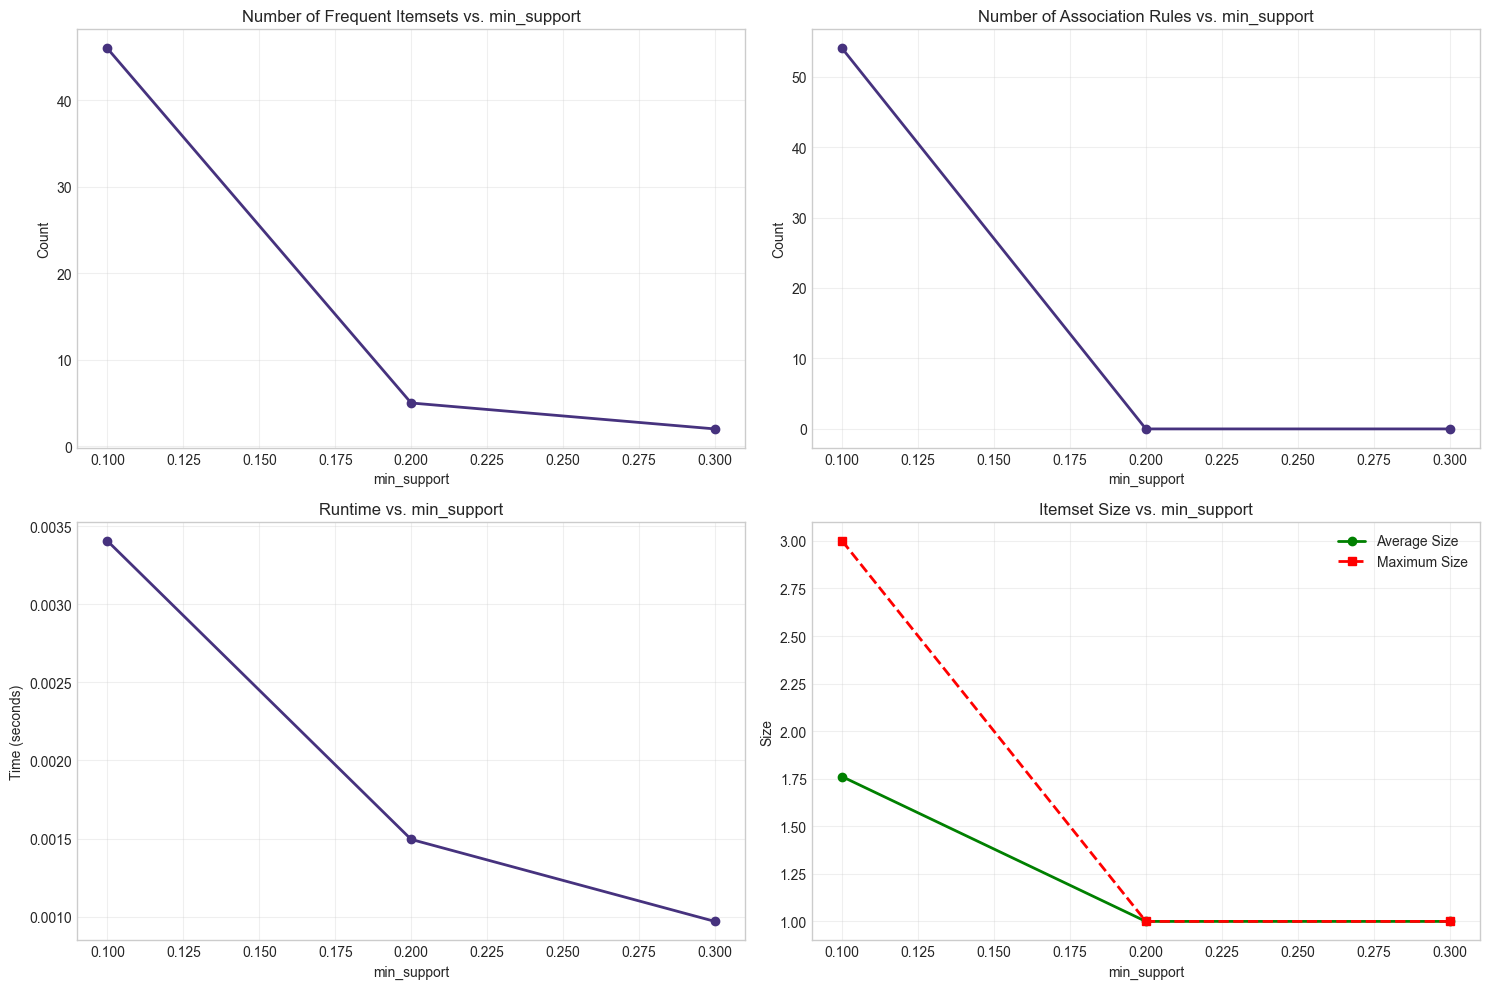

In [27]:
# Define min_support values for sensitivity analysis
min_support_values = [0.1, 0.2, 0.3]
sensitivity_results = {}

# Run FP-Growth with different min_support values (faster than Apriori)
for min_support in min_support_values:
    start_time = time.time()
    itemsets = fpgrowth(encoded_df, min_support=min_support, use_colnames=True)
    runtime = time.time() - start_time

    rules = association_rules(itemsets, metric="confidence", min_threshold=min_confidence)

    sensitivity_results[min_support] = {
        'itemsets_count': len(itemsets),
        'rules_count': len(rules),
        'runtime': runtime,
        'avg_itemset_size': itemsets['itemsets'].apply(len).mean(),
        'max_itemset_size': itemsets['itemsets'].apply(len).max()
    }

# Create DataFrame for visualization
sensitivity_df = pd.DataFrame.from_dict(sensitivity_results, orient='index')
sensitivity_df.index.name = 'min_support'
sensitivity_df.reset_index(inplace=True)

print("Sensitivity Analysis Results:")
display(sensitivity_df)

# Plot sensitivity analysis results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Itemsets count
axes[0, 0].plot(sensitivity_df['min_support'], sensitivity_df['itemsets_count'],
             marker='o', linestyle='-', linewidth=2)
axes[0, 0].set_title('Number of Frequent Itemsets vs. min_support')
axes[0, 0].set_xlabel('min_support')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3)

# Rules count
axes[0, 1].plot(sensitivity_df['min_support'], sensitivity_df['rules_count'],
             marker='o', linestyle='-', linewidth=2)
axes[0, 1].set_title('Number of Association Rules vs. min_support')
axes[0, 1].set_xlabel('min_support')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3)

# Runtime
axes[1, 0].plot(sensitivity_df['min_support'], sensitivity_df['runtime'],
             marker='o', linestyle='-', linewidth=2)
axes[1, 0].set_title('Runtime vs. min_support')
axes[1, 0].set_xlabel('min_support')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].grid(True, alpha=0.3)

# Avg itemset size
axes[1, 1].plot(sensitivity_df['min_support'], sensitivity_df['avg_itemset_size'],
             marker='o', linestyle='-', linewidth=2, color='green')
axes[1, 1].plot(sensitivity_df['min_support'], sensitivity_df['max_itemset_size'],
             marker='s', linestyle='--', linewidth=2, color='red')
axes[1, 1].set_title('Itemset Size vs. min_support')
axes[1, 1].set_xlabel('min_support')
axes[1, 1].set_ylabel('Size')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(['Average Size', 'Maximum Size'])

# Save the figure
plt.tight_layout()
plt.savefig('figures/sensitivity_analysis.png', dpi=300)
plt.show()

## Conclusion

In this notebook, we successfully:

1. Loaded and encoded transaction data
2. Applied the Apriori algorithm to find frequent itemsets
3. Applied the FP-Growth algorithm for comparison
4. Generated association rules from both algorithms
5. Visualized and compared the results

Key findings:
- FP-Growth generally outperforms Apriori in terms of execution time, especially as the dataset grows
- Both algorithms found the same frequent itemsets with the same parameters
- The min_support parameter significantly affects the number of frequent itemsets and rules discovered

In the next notebook, we'll explore closed itemsets and build a concept lattice to gain further insights from our frequent pattern mining results.

### Complexity Analysis

- **Apriori**:
  - Time Complexity: O(2^d * n), where d is the number of unique items and n is the number of transactions
  - Space Complexity: O(2^d)
  - Main bottleneck: Multiple database scans and candidate generation

- **FP-Growth**:
  - Time Complexity: O(n * d), where d is the number of unique items and n is the number of transactions
  - Space Complexity: O(n * d) for the FP-Tree
  - Main advantage: Single database scan and no candidate generation